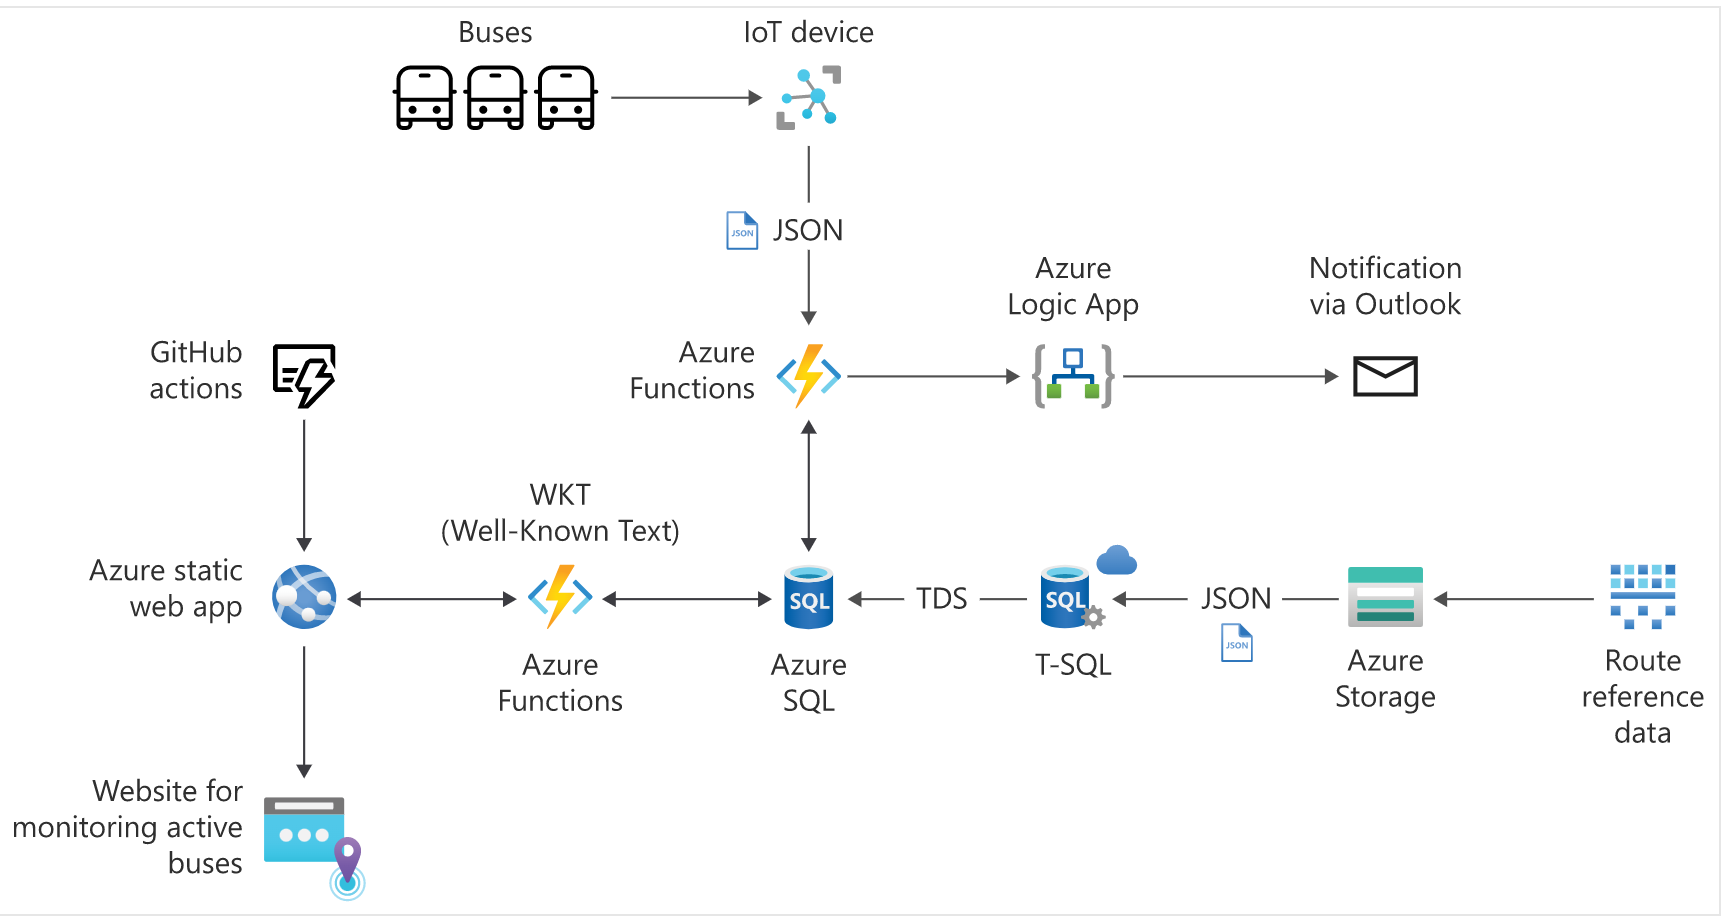

# Step 1: Create the Start-up Resources
- Create a resource group for managing all of the resources we are creating
- Create a storage account for specifically managing all azure data objects
- Create a cloud shell terminal resource
    - Select all the minimum basic requirements so payment is minimal
    - Note: Copying is normal for apple but for windows use (Shift + Insert Key)
- Eveyrthing else can be done through the shell
- Github details
    - Fork the repo, clone the repo

In [3]:
# Obtain your vpn information with the following code locally
# 147.222.236.134
(Invoke-WebRequest -Uri "https://ipinfo.io/ip").Content

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2074088276.py, line 2)

# Step 2: Set Up Out SQL Database Resource
- Adjust naming of sql server, resource group, database
- Make note of unique ID
- Script will also add IP address as a firewall rule which is nice
- Confirm deployment


In [ ]:
# Collect password 
$adminSqlLogin = "cloudadmin"
$password = Read-Host "Your username is 'cloudadmin'. Please enter a password for your Azure SQL Database server that meets the password requirements"
# Prompt for local ip address
$ipAddress = Read-Host "Disconnect your VPN, open PowerShell on your machine and run '(Invoke-WebRequest -Uri "https://ipinfo.io/ip").Content'. Please enter the value (include periods) next to 'Address': "
Write-Host "Password and IP Address stored"

In [ ]:
# Get resource group and location and random string
$resourceGroupName = "class-demo-group"
$resourceGroup = Get-AzResourceGroup | Where ResourceGroupName -like $resourceGroupName
$uniqueID = Get-Random -Minimum 100000 -Maximum 1000000
$location = $resourceGroup.Location
# The logical server name has to be unique in the system
$serverName = "demo-server$($uniqueID)"
# The sample database name
$databaseName = "class-sql-db"
Write-Host "Please note your unique ID for future exercises in this module:"  
Write-Host $uniqueID
Write-Host "Your resource group name is:"
Write-Host $resourceGroupName
Write-Host "Your resources were deployed in the following region:"
Write-Host $location
Write-Host "Your server name is:"
Write-Host $serverName

In [ ]:
# Create a new server with a system wide unique server name
$server = New-AzSqlServer -ResourceGroupName $resourceGroupName `
    -ServerName $serverName `
    -Location $location `
    -SqlAdministratorCredentials $(New-Object -TypeName System.Management.Automation.PSCredential -ArgumentList $adminSqlLogin, $(ConvertTo-SecureString -String $password -AsPlainText -Force))
# Create a server firewall rule that allows access from the specified IP range and all Azure services
$serverFirewallRule = New-AzSqlServerFirewallRule `
    -ResourceGroupName $resourceGroupName `
    -ServerName $serverName `
    -FirewallRuleName "AllowedIPs" `
    -StartIpAddress $ipAddress -EndIpAddress $ipAddress 
$allowAzureIpsRule = New-AzSqlServerFirewallRule `
    -ResourceGroupName $resourceGroupName `
    -ServerName $serverName `
    -AllowAllAzureIPs
# Create a database
$database = New-AzSqlDatabase  -ResourceGroupName $resourceGroupName `
    -ServerName $serverName `
    -DatabaseName $databaseName `
    -Edition "GeneralPurpose" -Vcore 1 -ComputeGeneration "Gen5" `
    -ComputeModel Serverless -MinimumCapacity 0.5
Write-Host "Database deployed."

In [ ]:
$storageAccountName = $("storageaccount$($uniqueID)")
$storageAccount = New-AzStorageAccount -ResourceGroupName $resourceGroupName -AccountName $storageAccountName -Location $location -SkuName Standard_GRS
$resourceGroupName = "class-demo-group"
$resourceGroup = Get-AzResourceGroup | Where ResourceGroupName -like $resourceGroupName
$uniqueID = Get-Random -Minimum 100000 -Maximum 1000000
$location = $resourceGroup.Location
# Azure function name
$azureFunctionName = $("azfunc$($uniqueID)")
# Get storage account name
$storageAccountName = (Get-AzStorageAccount -ResourceGroup $resourceGroupName).StorageAccountName
Write-Host "Your storage account name is:"
Write-Host $storageAccountName

# Step 6: Deploy the Azure Function
- This function app will manage the connection between the IOT device and the SQL DB

In [ ]:
$functionApp = New-AzFunctionApp -Name $azureFunctionName `
    -ResourceGroupName $resourceGroupName -StorageAccount $storageAccountName `
    -FunctionsVersion 3 -RuntimeVersion 3.8 -Runtime python -Location $location

# Step 7: Deploy an Azure Logic App
- Have your GitHub Repo ready to copy
    - Forked Repo URL: https://github.com/matt1moore/serverless-full-stack-apps-azure-sql.git
    

In [ ]:
# Resource group name and resource group
$resourceGroupName = "class-demo-group"
$resourceGroup = Get-AzResourceGroup | Where ResourceGroupName -like $resourceGroupName
$location = $resourceGroup.Location
# Get the repository name
$appRepository = Read-Host "Enter your GitHub repository URL (for example, 'https://github.com/[username]/serverless-full-stack-apps-azure-sql'):"
# Clone the repo - note this asks for the token
$cloneRepository = git clone $appRepository
# Get subscription ID 
$subId = [Regex]::Matches($resourceGroup.ResourceId, "(\/subscriptions\/)+(.*\/)+(.*\/)").Groups[2].Value
$subId = $subId.Substring(0,$subId.Length-1)
# Deploy logic app
az deployment group create --name DeployResources --resource-group $resourceGroupName `
    ` --template-file ./serverless-full-stack-apps-azure-sql/deployment-scripts/template.json `
    --parameters subscription_id=$subId location=$location  
Write-Host "Logic App deployed."

# Step 8: Configure the Logic App
- Adjust the HTTP POST URL
- Adjust the request JSON Schema
- Sign into your outlook account
- Adjust the Body, Subject and To clauses of the email

# Step 9: Configure the Azure Function

In [ ]:
# Determine the connection string for the database
# This can be found easily within the Azure Web App in ODBC formatting
# Driver={ODBC Driver 17 for SQL Server};Server=[serverName].database.windows.net,1433;Database=demo-sql-db;UID=cloudadmin;PWD=[yourPassword];Connection Timeout=30;

# Step 9: Deploy a Static Web App
- First go into github and generate a new token checking all the boxes

In [ ]:
# Get resource group and location and random string
$resourceGroupName = "demo-resource"
$resourceGroup = Get-AzResourceGroup | Where ResourceGroupName -like $resourceGroupName
$uniqueID = Get-Random -Minimum 100000 -Maximum 1000000
$location = $resourceGroup.Location
# Azure static web app name
$webAppName = $("demo-app$($uniqueID)")
# Get the repository name
$appRepository = Read-Host "Please enter the forked URL (for example, https://github.com/<username>/serverless-full-stack-apps-azure-sql):"
# Get user's GitHub personal access token
$githubToken = (Read-Host "In your GitHub account settings, near the bottom left, select Developer settings > Personal access tokens > check all boxes and generate the token. Enter the token").ToString()
# App service plan name
$appServicePlanName = (Get-AzAppServicePlan -resourceGroupName $resourceGroupName).Name

In [ ]:
# Deploy Azure static web app
$staticWebApp = az staticwebapp create -n $webAppName -g $resourceGroupName `
-s $appRepository -l 'westus2' -b main --token $githubToken
Write-Host "Azure Static Web App deployed."

# Step 10: Set up GitHub Actions & Workflow
1. Database set up
    1. Note your DB connection string
    1. Note this as a new secret repo key-value pair called AZURE_SQL_CONNECTION_STRING
    1. Configure the web app yml file correctly
    1. Push this config
1. Function app set up
    1. In the azure portal overview tab, get publish profile
    1. Note this as a new secret repo key_valeu pair called AZURE_FUNCTIONAPP_PUBLISH_PROFILE
    1. Configure the yml accordingly
1. Static Web application set up
    1. Grab your Azure connection string
    1. Under configuration of the web app add a key value pair with key called AzureSQLConnectionString

- Make sure the the location of the static web app client/api/python and configured
    - Make sure the language of the function app is correct
- Double check the connection string is in ADO.NET formatting

# Step 11: Set Up Query Information

In [ ]:
ALTER DATABASE SCOPED CREDENTIAL AzureBlobCredentials
WITH IDENTITY = 'SHARED ACCESS SIGNATURE',
SECRET = 'sp=r&st=2021-03-12T00:47:24Z&se=2025-03-11T07:47:24Z&spr=https&sv=2020-02-10&sr=c&sig=BmuxFevKhWgbvo%2Bj8TlLYObjbB7gbvWzQaAgvGcg50c%3D';
DROP EXTERNAL DATA SOURCE RouteData;
CREATE EXTERNAL DATA SOURCE RouteData
WITH (
    TYPE = blob_storage,
    LOCATION = 'https://azuresqlworkshopsa.blob.core.windows.net/bus',
    CREDENTIAL = AzureBlobCredentials
);
DELETE FROM dbo.[Routes];
INSERT INTO dbo.[Routes]
([Id], [AgencyId], [ShortName], [Description], [Type])
SELECT 
[Id], [AgencyId], [ShortName], [Description], [Type]
FROM
openrowset
(
    bulk 'routes.txt', 
    data_source = 'RouteData', 
    formatfile = 'routes.fmt', 
    formatfile_data_source = 'RouteData', 
    firstrow=2,
    format='csv'
) t;
SET QUOTED_IDENTIFIER ON;
SET ANSI_NULLS ON;
INSERT INTO dbo.[GeoFences] 
    ([Name], [GeoFence]) 
VALUES
    ('Crossroads', 0xE6100000010407000000B4A78EA822CF4740E8D7539530895EC03837D51CEACE4740E80BFBE630895EC0ECD7DF53EACE4740E81B2C50F0885EC020389F0D03CF4740E99BD2A1F0885EC00CB8BEB203CF4740E9DB04FC23895EC068C132B920CF4740E9DB04FC23895EC0B4A78EA822CF4740E8D7539530895EC001000000020000000001000000FFFFFFFF0000000003);
INSERT INTO dbo.[MonitoredRoutes] (RouteId) VALUES (100113);
GO

# Step 11: Confirm Deployment
- Monitor our azure function, make sure it is operating correctly
- If not, test it with the input json file
- Likely need to add correct authentication



# Step 12: Check out the App
- Add ?rid=100113&gid=2 to the end of the URL and refresh for the live data
